# Language_Detection

Celem projektu jest automatyczne rozpoznawanie języka tekstu na podstawie krótkich próbek. Model został wytrenowany na zbiorze danych zawierającym teksty w 17 językach, z wykorzystaniem technik NLP (TF-IDF) i algorytmu klasyfikacyjnego.

In [20]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Wczytywanie danych

In [23]:
data = pd.read_csv("..\input\Sample_Language.csv")

In [25]:
data.head()

,Unnamed: 0,Text,Language
0,0,NaN,English
1,1,Wikipedia[c] is a free-content online encyclop...,English
2,2,"Initially available only in English, Wikipedia...",English
3,3,Wikipedia has been praised for enabling the de...,English
4,4,Various collaborative online encyclopedias wer...,English


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8161 non-null   int64 
 1   Text        7988 non-null   object
 2   Language    8161 non-null   object
dtypes: int64(1), object(2)
memory usage: 191.4+ KB


In [69]:
data.isnull().sum()


Unnamed: 0    0
Text          0
Language      0
dtype: int64

In [75]:
data = data.dropna(subset=['Text'])

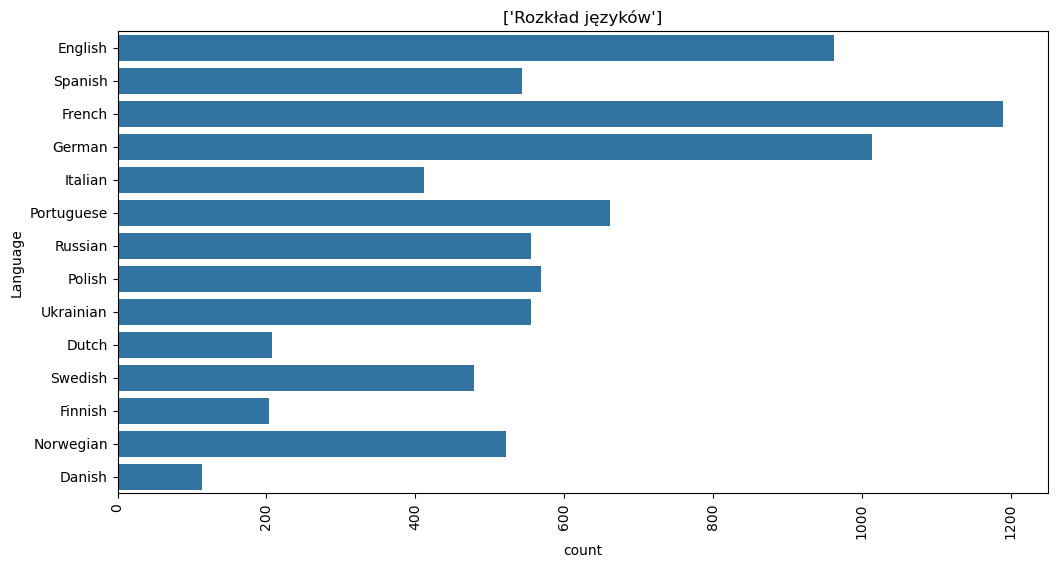

In [77]:
plt.figure(figsize=(12,6))
sns.countplot(data['Language'])
plt.title(['Rozkład języków'])
plt.xticks(rotation= 90)
plt.show()

In [79]:
data['Language'].value_counts()

Language
French        1190
German        1014
English        962
Portuguese     661
Polish         569
Russian        555
Ukrainian      555
Spanish        543
Norwegian      522
Swedish        479
Italian        412
Dutch          208
Finnish        204
Danish         114
Name: count, dtype: int64

## Preprocessing

In [82]:
def clean_text(text):
    text = re.sub(r'[!@#$(),\n"%^*?\:;~`0-9]', ' ', text) # zastepuje wszystkie wymienione znaki spacja
    text = re.sub(r'[\[\]]', ' ', text) # zastepuje nawiasy kwadratowe spacją
    return text.lower()

In [84]:
data["Text"] = data["Text"].apply(clean_text)

In [86]:
data.sample(10)

,Unnamed: 0,Text,Language
46,46,in addition to the top six twelve other wikip...,English
5747,5747,stosując stworzoną przez siebie metodę sum cał...,Polish
2783,2783,den größten persönlichen einfluss – vor allem ...,German
5408,5408,третья категория продукции мячи сумки и др. ...,Russian
2361,2361,en novembre la capitalisation boursière ...,French
285,285,in the palais de la découverte a science muse...,English
618,618,the minuscule letter ω is used as a symbol,English
6271,6271,працюючи за цією схемою достатньо зробити ...,Ukrainian
4752,4752,no dia de outubro de deu um grande pa...,Portuguese
890,890,in september english fashion designer st...,English


## Rozdzielenie danych

In [89]:
X = data["Text"]
y = data["Language"]

## Zamiana zmiennych kategorialnych na numeryczne

In [92]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## Walidacja danych

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

## Torby słów

TfidfVectorizer służy do konwersji danych teskowych na cechy numeryczne które bierze pod uwage:
- Unigramy (pojedyncze słowa, np. "Harry", "Potter")
- Bigramy (pary słów, np. "Harry Potter", "Potter i")


In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [101]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)
x_train = tfidf.transform(X_train).toarray()
x_test = tfidf.transform(X_test).toarray()


In [102]:
print(x_train.shape)
print(x_test.shape)


(6390, 246554)
(1598, 246554)


## Budowanie modelu 

Model którego uzyje to klasyfikator bayesowski, a konkretnie jego wariant dla cech dyskretnych – Multinomial Naive Bayes (MultinomialNB).
MultinomialNB wykorzystuje twierdzenie Bayesa z założeniem (tzw. "naive" – naiwnym) o niezależności cech. Model ten jest szczególnie przydatny przy danych, gdzie cechy mają charakter dyskretny, np. liczby wystąpień słów w dokumentach.
Jest często wykorzystywany do zadań takich jak filtrowanie spamu, analiza sentymentu czy kategoryzacja dokumentów.

In [105]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [106]:
model = MultinomialNB()
params = {'alpha':[0.01,0.1,0.5,1]}


In [107]:
grid_search = GridSearchCV(model, param_grid= params, cv=5, scoring= 'accuracy')

In [113]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1]}, scoring='accuracy')

In [114]:
best_model = grid_search.best_estimator_

In [115]:
results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.589671,2.108904,0.452892,0.041176,0.01,{'alpha': 0.01},0.978873,0.979656,0.985133,0.982786,0.981221,0.981534,0.002246,1
1,3.435099,0.070145,0.409866,0.004682,0.10,{'alpha': 0.1},0.976526,0.973396,0.976526,0.980438,0.974961,0.976369,0.002342,2
2,4.082785,0.698515,0.451487,0.033835,0.50,{'alpha': 0.5},0.948357,0.948357,0.943662,0.953052,0.942097,0.947105,0.003884,3
3,4.076876,0.793721,0.428534,0.038891,1.00,{'alpha': 1},0.923318,0.921753,0.924100,0.930360,0.922535,0.924413,0.003075,4


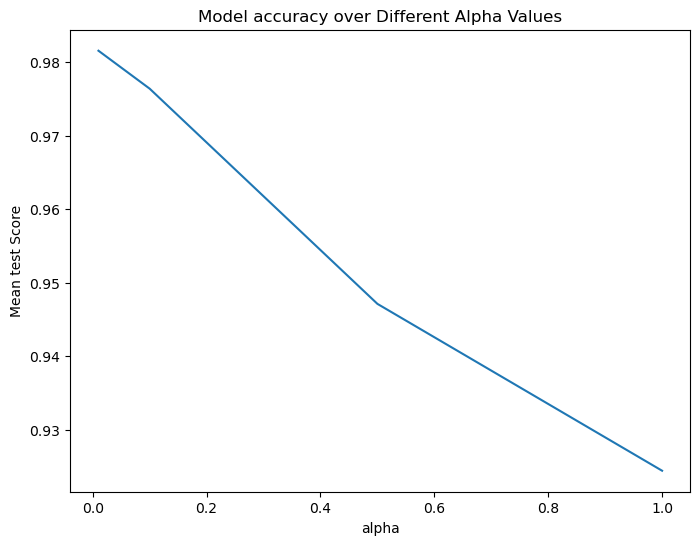

In [116]:
plt.figure(figsize=(8,6))
sns.lineplot(x='param_alpha', y= 'mean_test_score', data=results)
plt.title('Model accuracy over Different Alpha Values')
plt.xlabel('alpha')
plt.ylabel('Mean test Score')
plt.show()

Wartościach alfa wizualizacja dokładności modelu na róznych wartościach hiperparametru alpha w celu zidentyfikowania optymalnej wartosci

In [118]:
y_pred = best_model.predict(x_test)

## Ocena modelu 

In [120]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9824780976220275
Confusion Matrix:
[[ 14   0   0   0   2   0   0   6   0   0   0   0   0   0]
 [  0  44   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0 197   0   0   0   0   0   0   2   0   0   0   1]
 [  0   0   0  42   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 247   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   1 204   0   0   0   0   0   0   0   0]
 [  0   0   0   0   3   1  93   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 107   0   0   0   0   0   0]
 [  0   0   1   0   3   1   0   1 110   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 113   0   0   0   0]
 [  0   0   0   0   3   0   0   0   0   0 107   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  90   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  95   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0 107]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78     

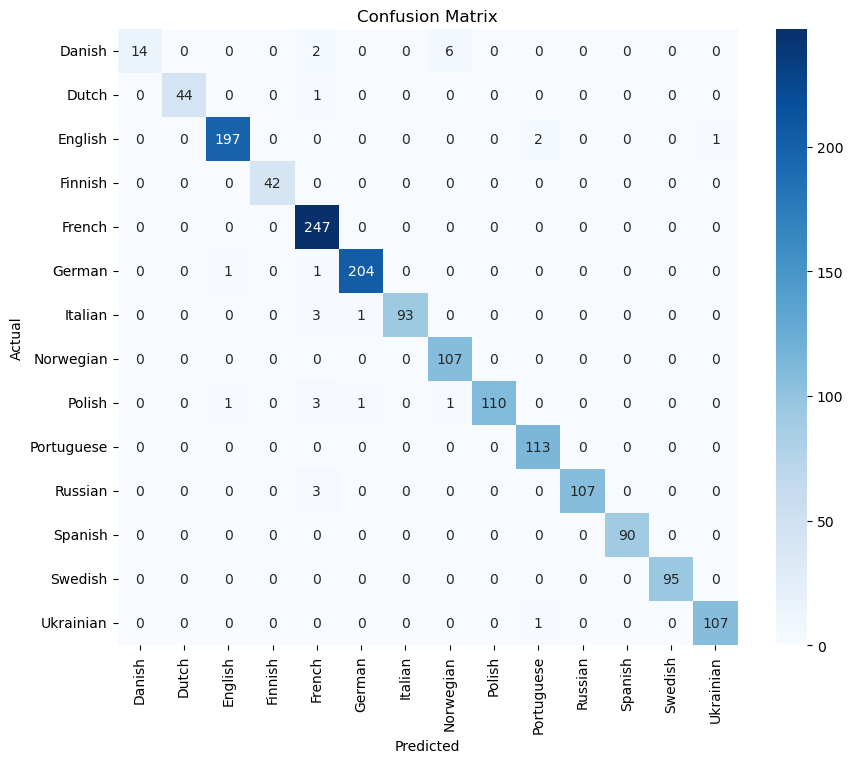

In [121]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot= True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model Deployment

### Tworzenie Potoku

In [124]:
from sklearn.pipeline import Pipeline

In [125]:
pipeline = Pipeline([
    ('vectorizer', tfidf),
    ('multinomialNB', best_model)
])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('multinomialNB', MultinomialNB(alpha=0.01))])

Potok ten obejmuje wektoryzator tfidf i najlepszy model multinomialNB dopasują sie do potoku na danych treningowych.
Potok łączy preprocessing (TF-IDF) i model w jeden obiekt, co upraszcza kod i eliminuje ryzyko błędów.

## Zapisywanie modelu 

In [128]:
with open('..\model\Pipeline_and_model_Language_Detection-0.1.0.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# TEST MODELU

In [130]:
text = 'Hello'
y= pipeline.predict([text])
print(le.classes_[y[0]])

Russian


In [131]:
text = 'Hallo'
y= pipeline.predict([text])
print(le.classes_[y[0]])

French


In [132]:
text = 'Как вы' # jak sie masz
y= pipeline.predict([text])
print(le.classes_[y[0]])

Russian


In [133]:
text = 'Como vai' # jak sie masz
y= pipeline.predict([text])
print(le.classes_[y[0]])

Portuguese


# Model Poprawnie rozpoznaje języki